In [1]:
# Parameters (default values will be overwritten by Papermill)
input_dir = "default_input_dir"
output_dir = "default_output_dir"
input_model_name = "default_input_model_name"
input_model_path = "default_model_save_path"

# classify_reconstruced_images

In [2]:
## Import Statements -> need to check which are not needed here
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image

import torch

from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch.nn as nn

import torch.optim as optim
import torch.nn as nn

from sklearn.metrics import f1_score

import os

import timm  # To use the TinyViT model

import matplotlib.pyplot as plt
from PIL import Image

import json
import os
# set constants
#SEED = 19
CLASSES_NO = 37

2025-01-30 16:53:25.434273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-30 16:53:25.668351: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 16:53:26.541047: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-30 16:53:26.541144

In [3]:
#model_name = "apple/mobilevit-xx-small"
model_name = "tiny_vit_5m_224"
model_save_path = f"models/tiny_vit_5m_224_2025-01-06_17-38.pth"
#model_save_path = f"models/apple_mobilevit-xx-small_2025-01-06_16-59.pth"
transparency = "small"
#model_name = input_model_name
#model_save_path = input_model_path

In [4]:
num_classes = 37  # Update this if you have a different number of classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if model_name == "apple/mobilevit-xx-small":
    print("Using MobileViT")
    # Load the processor
    processor = AutoImageProcessor.from_pretrained(model_name)

    # Load the pretrained model
    model = AutoModelForImageClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )
    # Update the classifier to match the dataset classes
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)

elif model_name == "tiny_vit_5m_224":
    print("Using TinyViT")
    # Import timm for TinyViT model loading
    import timm

    # Load the pretrained TinyViT model
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

else:
    raise ValueError("Unsupported model type. Please use MobileViT or TinyViT.")

# Load fine-tuned weights
try:
    model.load_state_dict(torch.load(model_save_path))
    print("Model weights loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError(f"Model weights not found at {model_save_path}")

# Move model to the appropriate device
model = model.to(device)
model.eval()  # Set the model to evaluation mode

Using TinyViT


/tmp/ipykernel_1329/3944885111.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Model weights loaded successfully.


TinyVit(
  (patch_embed): PatchEmbed(
    (conv1): ConvNorm(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act): GELU(approximate='none')
    (conv2): ConvNorm(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stages): Sequential(
    (0): ConvLayer(
      (blocks): Sequential(
        (0): MBConv(
          (conv1): ConvNorm(
            (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (act1): GELU(approximate='none')
          (conv2): ConvNorm(
            (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256, bias=Fals

In [5]:
# Define image preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(           # Normalize with ImageNet statistics
        #mean=[0.485, 0.456, 0.406],
        mean = [0.4784, 0.4460, 0.39609],
        #std=[0.229, 0.224, 0.225]
        std = [0.2245, 0.2216, 0.2227]        
    )
])


In [6]:
def classify_images_from_folder(folder_path, model, transform, device):
    predictions = []

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)

        # Skip non-image files
        if not image_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        # Open and preprocess the image
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Perform inference
        with torch.no_grad():
            outputs = model(input_tensor).logits
            predicted_class = torch.argmax(outputs, dim=1).item()
            predictions.append({"image_name": image_name, "predicted_class": predicted_class})

    # Return predictions as a DataFrame
    return pd.DataFrame(predictions)


In [7]:
def classify_images_from_folder(folder_path, model, transform, device):
    predictions = []

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)

        # Skip non-image files
        if not image_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        # Open and preprocess the image
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Perform inference
        with torch.no_grad():
            outputs = model(input_tensor)  # Get raw model output
            if isinstance(outputs, torch.Tensor):  # Check if it's a PyTorch model
                predicted_class = torch.argmax(outputs, dim=1).item()
            else:  # Assume it's a Hugging Face model output
                predicted_class = torch.argmax(outputs.logits, dim=1).item()
            predictions.append({"image_name": image_name, "predicted_class": predicted_class})

    # Return predictions as a DataFrame
    return pd.DataFrame(predictions)

In [8]:
# Define paths to the folders
reconstruced_folder = f"./data/images_cleaned_{transparency}/test" # FOLDER NEED TO BE REPLACED
#trainval_folder = "./data/resized_images/trainval"

# Classify images in test folder
reconstructed_predictions = classify_images_from_folder(reconstruced_folder, model, transform, device)

In [9]:
# Load ground truth data
pet_dataset_info = pd.read_csv("./data/pet_dataset_info.csv")

# Display first few rows
print(pet_dataset_info.head())

       image_name                                         image_path  class  \
0    Abyssinian_1    ./data/resized_images/trainval/Abyssinian_1.jpg    1.0   
1   Abyssinian_10   ./data/resized_images/trainval/Abyssinian_10.jpg    1.0   
2  Abyssinian_100  ./data/resized_images/trainval/Abyssinian_100.jpg    1.0   
3  Abyssinian_101  ./data/resized_images/trainval/Abyssinian_101.jpg    1.0   
4  Abyssinian_102  ./data/resized_images/trainval/Abyssinian_102.jpg    1.0   

       fold  
0  trainval  
1  trainval  
2  trainval  
3  trainval  
4  trainval  


In [10]:
print(reconstructed_predictions.head())

                 image_name  predicted_class
0   yorkshire_terrier_7.jpg               12
1  yorkshire_terrier_51.jpg               36
2  yorkshire_terrier_52.jpg               36
3   yorkshire_terrier_8.jpg               36
4   yorkshire_terrier_9.jpg               36


In [11]:
# Adjust the predicted_class by adding 1
reconstructed_predictions["predicted_class"] = reconstructed_predictions["predicted_class"] + 1

# Merge test predictions with ground truth
reconstructed_predictions["image_name"] = reconstructed_predictions["image_name"].map(lambda x: x.replace(".jpg", ""))
reconstructed_comparison = pd.merge(reconstructed_predictions, pet_dataset_info, on="image_name", how="inner")

# Check if predictions match ground truth
reconstructed_comparison["is_correct"] = reconstructed_comparison["predicted_class"] == reconstructed_comparison["class"]


# Display comparisons
print(reconstructed_comparison[["image_name", "predicted_class", "class", "is_correct"]])

                image_name  predicted_class  class  is_correct
0      yorkshire_terrier_7               13   37.0       False
1     yorkshire_terrier_51               37   37.0        True
2     yorkshire_terrier_52               37   37.0        True
3      yorkshire_terrier_8               37   37.0        True
4      yorkshire_terrier_9               37   37.0        True
...                    ...              ...    ...         ...
3664        Abyssinian_226                9    1.0       False
3665        Abyssinian_228                6    1.0       False
3666        Abyssinian_230                1    1.0        True
3667        Abyssinian_232                1    1.0        True
3668   yorkshire_terrier_6                6   37.0       False

[3669 rows x 4 columns]


In [12]:
# Calculate accuracy for test data
#test_accuracy = reconstruced_comparison["is_correct"].mean()
#print(f"Test Accuracy: {test_accuracy:.2%}")

In [13]:
# Save test predictions
if model_name == "apple/mobilevit-xx-small":
    model_name ="mobilevit-xx-small"
reconstructed_comparison.to_csv(f"./data/reconstructed_comparison_{model_name}_{transparency}.csv", index=False)
print(f"Reconstructed comparison saved to ./data/reconstructed_comparison_{model_name}_{transparency}.csv")

Reconstructed comparison saved to ./data/reconstructed_comparison_tiny_vit_5m_224_small.csv


# Calculate accuracy for test data
test_accuracy = reconstruced_comparison["is_correct"].mean()
print(f"Test Accuracy: {test_accuracy:.2%}")

#from sklearn.metrics import f1_score

# For test data
y_pred_test = reconstructed_comparison["predicted_class"]
y_true_test = reconstructed_comparison["class"]  

f1_test_weighted = f1_score(y_true_test, y_pred_test, average="weighted")
f1_test_macro = f1_score(y_true_test, y_pred_test, average="macro")

print(f"Test F1 Score (Weighted): {f1_test_weighted:.4f}")
print(f"Test F1 Score (Macro): {f1_test_macro:.4f}")

In [14]:
import json
import os

# Calculate accuracy for test data
test_accuracy = reconstructed_comparison["is_correct"].mean()
print(f"Test Accuracy: {test_accuracy:.2%}")

# Calculate F1 scores for test data
y_pred_test = reconstructed_comparison["predicted_class"]
y_true_test = reconstructed_comparison["class"]

f1_test_weighted = f1_score(y_true_test, y_pred_test, average="weighted")
f1_test_macro = f1_score(y_true_test, y_pred_test, average="macro")

print(f"Test F1 Score (Weighted): {f1_test_weighted:.4f}")
print(f"Test F1 Score (Macro): {f1_test_macro:.4f}")

# Save results to a dictionary
test_metrics = {
    "test_accuracy": test_accuracy,
    "f1_test_weighted": f1_test_weighted,
    "f1_test_macro": f1_test_macro
}

# Define the output directory and file
output_dir = f"output/reconstructed_metrics_{model_name}_{transparency}"
os.makedirs(output_dir, exist_ok=True)
metrics_path = os.path.join(output_dir, "reconstructed_metrics.json")

# Save the metrics to a JSON file
with open(metrics_path, "w") as f:
    json.dump(test_metrics, f, indent=4)

print(f"reconstructed metrics saved to {metrics_path}")

Test Accuracy: 54.18%
Test F1 Score (Weighted): 0.5439
Test F1 Score (Macro): 0.5429
reconstructed metrics saved to output/reconstructed_metrics_tiny_vit_5m_224_small/reconstructed_metrics.json


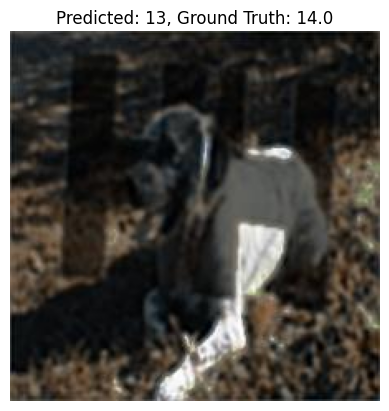

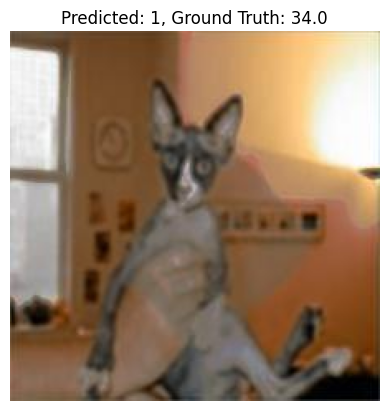

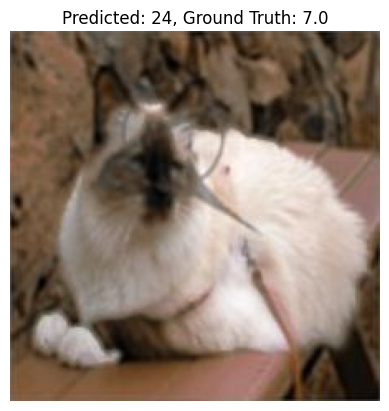

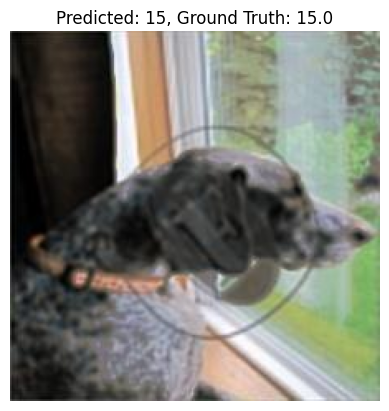

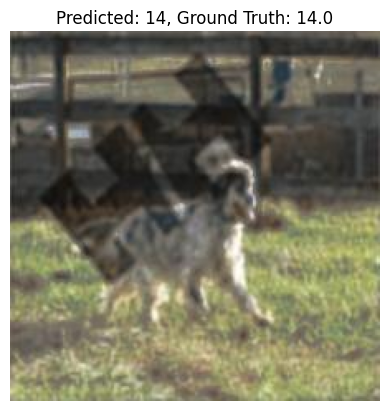

In [15]:
import matplotlib.pyplot as plt
from PIL import Image

# Display 5 random classified images with labels
sampled_df = reconstructed_comparison.sample(5)
for _, row in sampled_df.iterrows():
    image_path = os.path.join(reconstruced_folder, f"{row['image_name']}.jpg")  # Adjust folder as needed
    image = Image.open(image_path)
    
    # Display the image inline
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {row['predicted_class']}, Ground Truth: {row['class']}")
    plt.show()